In [ ]:
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import *
import networkx as nx

In [ ]:
device = torch.device("cpu")

In [ ]:
import random

class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192, is_cold=True):
        """
        Args:
            model: Neural network to use for modeling E_theta
            img_shape: Shape of the images to model
            sample_size: Batch size of the samples
            max_len: Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]
        self.is_cold=is_cold

    def sample_new_exmps(self, steps=60, step_size=10):
        """Function for getting a new batch of "fake" images.

        Args:
            steps: Number of iterations in the MCMC algorithm
            step_size: Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach()

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, is_cold=self.is_cold)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device(device)).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[: self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False, is_cold=True):
        """Function for sampling images for a given model.

        Args:
            model: Neural network to use for modeling E_theta
            inp_imgs: Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps: Number of iterations in the MCMC algorithm.
            step_size: Learning rate nu in the algorithm above
            return_img_per_step: If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            if is_cold:
                out_imgs = -model(inp_imgs, is_cold=True)
            else:
                out_imgs = -model(inp_imgs, is_cold=False)

            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)  # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [ ]:
class FastSlowMixture(torch.nn.Module):
    def __init__(self, dimension, rho):
        """
        The Model parameters.
        """
        super().__init__()

        self.l1 = torch.nn.Parameter(torch.empty(300, dimension))
        torch.nn.init.kaiming_uniform_(self.l1, a=5**0.5)

        self.l2 = torch.nn.Parameter(torch.empty(100, 300))
        torch.nn.init.kaiming_uniform_(self.l2, a=5**0.5)

        self.l3 = torch.nn.Parameter(torch.empty(1, 100))
        torch.nn.init.kaiming_uniform_(self.l3, a=5**0.5)

        self.a2 = torch.nn.ReLU()
        self.a1 = torch.nn.ReLU()

        self.rho = rho

    def forward(self, x, is_cold=True):

        temp = self.rho * (1. - is_cold) + is_cold

        out = x
        out = torch.nn.functional.linear(out, temp * self.l1)
        out = self.a1(out)
        out = torch.nn.functional.linear(out, temp * self.l2)
        out = self.a2(out)
        out = torch.nn.functional.linear(out, temp * self.l3)

        return out



In [ ]:
with device:
  net = FastSlowMixture(3, 0.001)
  input = torch.tensor([[-1.,1.,1.], [0.1, 0.,-1.]])
  print(net(input, is_cold=False))

tensor([[-7.0711e-11],
        [ 1.0363e-11]], grad_fn=<MmBackward0>)


In [ ]:
def cost(G, batch):
    return torch.einsum('ij, si, sj -> s', G, batch, batch)/4.


def int_to_binary(num, length):
  bin_str = bin(num)[2:]

  # Pad the binary string with leading zeros as necessary
  bin_str = '{:0>{}}'.format(bin_str, length)

  # Convert the binary string to a binary vector
  return torch.tensor([2*int(digit) - 1. for digit in bin_str])

def P_value(cut_value, d, n):
   return (cut_value/n - d/4.) / (d/4.)**(0.5)

def max_cut_loss(log_density, P_value, reg_value=0.):
    # dimension = torch.shape(L)[0]
    # avg_degree = torch.mean(torch.diagonal(L))

    log_density = log_density - torch.max(log_density)

    loss = -torch.mean(P_value * log_density) + torch.mean(P_value) * torch.mean(log_density)

    ent_reg =  reg_value * (torch.mean(log_density * log_density) - torch.mean(log_density) * torch.mean(log_density))

    return loss + ent_reg


In [ ]:
def vanilla_cut_optimizer(net, opt, mala_sampler, mala_steps, iterations, L):
    losses_vanilla = []
    out = None
    degree = torch.mean(torch.diag(L))
    dimension = L.shape[0]

    for step in range(iterations):
        net.train()
        opt.zero_grad()
        m = torch.nn.Softsign()
        # m = torch.nn.Sigmoid()

        # Mala sampling
        X = torch.Tensor.detach(mala_sampler.sample_new_exmps(steps=mala_steps))
        rounded_X = torch.sign(X)
        # X = 2*m(X) - 1.
        X = rounded_X

        out = net(X).squeeze()
        score = P_value(cost(L, X), degree, dimension)

        loss = max_cut_loss(out, score)

        rounded_score = P_value(cost(L, rounded_X), degree, dimension)

        mean_score = torch.max(rounded_score).item()

        if step % 10 == 0:
            print("Step", step, "Mean Batch Score", mean_score)

        loss.backward()

        opt.step()
        losses_vanilla.append(mean_score)
    return out, losses_vanilla


In [ ]:
def hot_cold_cut_optimizer(net, opt, mala_sampler_cold, mala_sampler_hot,
                           mala_steps, iterations, L,
                           reg_value, reg_updates, reg_scaling, mix_prob):
    losses_regularized = []
    cold_out = None

    degree = torch.mean(torch.diag(L))
    dimension = L.shape[0]

    new_reg_value = reg_value
    iter_split = np.array_split(np.array(range(iterations)), reg_updates)

    total_iterations = 0

    for x in iter_split:
      reg_iterations = len(x)
      new_reg_value = new_reg_value / reg_scaling

      for step in range(reg_iterations):
        net.train()
        opt.zero_grad()


        # Mala Sampling
        cold_sample = torch.Tensor.detach(mala_sampler_cold.sample_new_exmps(steps=mala_steps))
        cold_sample = torch.sign(cold_sample)
        # m = torch.nn.Softsign()
        # cold_sample = m(cold_sample)

        cold_sample_rounded = torch.sign(cold_sample)

        cold_out = net(cold_sample).squeeze()
        score = P_value(cost(L, cold_sample), degree, dimension)
        score_rounded = P_value(cost(L, cold_sample_rounded), degree, dimension)

        loss = max_cut_loss(cold_out, score, reg_value=new_reg_value)


        hot = torch.Tensor.detach(mala_sampler_hot.sample_new_exmps(steps=mala_steps))
        hot = torch.sign(hot)
        # hot = m(hot)

        out_hot = net(hot, is_cold=False).squeeze()
        score_hot = P_value(cost(L, hot), degree, dimension)

        mean_score_hot = torch.mean(score_hot).item()
        if (step + total_iterations) % 10 == 0:
          print("Step", step + total_iterations, "The score of hot samples ", mean_score_hot, torch.mean(cost(L,hot)).item())

        loss_hot = max_cut_loss(out_hot, score_hot)

        loss = (1-mix_prob) * loss + mix_prob * loss_hot

        loss.backward()

        opt.step()

        mean_score = torch.mean(score_rounded).item()

        if (step + total_iterations) % 10 == 0:
          print("Step", step + total_iterations, "The score of cold samples", mean_score, torch.mean(cost(L, cold_sample)).item())

        losses_regularized.append(mean_score)
      total_iterations += reg_iterations
    return cold_out, losses_regularized


In [ ]:
import cvxpy as cp
import numpy as np
import networkx as nx


def goemans_williamson(G):
    """
    Approximate max cut using Goemans-Williamson SDP relaxation.
    """

    # Create variables
    n = len(G)

    X = cp.Variable((n, n), PSD=True)

    # Create constraints
    constraints = [cp.diag(X) == 1]
    objective = cp.Maximize(cp.trace(X@G)/4)

    # Define and solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # print(P_value(objective.value, degree, dimension))

    # Random hyperplane
    r = np.random.normal(size=(n, 1))

    # Compute GW cut
    cut = (np.dot(X.value, r) >= 0).flatten()
    return 2*cut - 1.


    # S = [i for i in range(n) if cut[i]]
    # T = [i for i in range(n) if not cut[i]]

    # return S, T

In [ ]:
import time
t0 = time.time()

# with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with torch.profiler.record_function("model_inference"):

trials = 2
dimension = 500
degree = 20
iterations_vanilla = 1000
iterations_regularized = 1000
step_size = 0.003
batch_size = 200
mala_steps = 1000
find_opt = False
new_reg_value = 5.
mix_prob = 0.05
rho = 0.03

optimal_values = []
vanilla_trajectories = []

vanilla_scores = []
reg_trajectories = []

reg_scores = []
cut_value_list = []

for j in range(trials):
  G = nx.to_numpy_array(
      # nx.generators.random_graphs.gnp_random_graph(dimension, 0.5)).astype(int)
      nx.generators.random_graphs.random_regular_graph(degree, dimension)).astype(int)


  Gt = torch.tensor(G, dtype=torch.float)

  L = (torch.diag(torch.sum(Gt, axis=1)) - Gt).to(device)
  degree = torch.mean(torch.diag(L))
  print("Avg Degree", degree)

  if find_opt:

    def s(n):
        return np.array( [int(x) for x in bin(2**dimension + n)[2:]][1:] )
    def cut(n):
        return np.sum( G & (s(n)[:,None] < s(n)) )
    def st(n):
        return torch.tensor( [int(x) for x in bin(2**dimension + n)[2:]][1:] ).float()

    X = torch.stack([st(i) for i in range(2**dimension)])
    y = torch.tensor([cut(i) for i in range(2**dimension)]).float()
    opt = torch.max(y)
    print("The value of Max-Cut is:", P_value(torch.max(y), degree, dimension), torch.max(y))

  else:
    y = []
    opt = -1.

  print("Trial:", j)

  cut_value_list.append(y)
  optimal_values.append(opt)

  # GW baseline

  # G = (np.diag(np.sum(G, axis=1)) - G).astype(float)
  # Lnp = L.numpy()

  # gw_cut = torch.tensor(
  #     [goemans_williamson( L.numpy() ) ], dtype=torch.float32)
  # print(gw_cut)
  # print(L)
  # gw_cost = cost(L, gw_cut)
  # print(gw_cut)
  # print(G)
  # print("GW Score", P_value(gw_cost, degree, dimension) )

  # Vanilla Cut Optimizer
  with device:

    net = FastSlowMixture(dimension, 1.)
    # Define Optimizer
    opt = torch.optim.Adam(net.parameters(), lr=step_size)

    # Define MALA sampler
    mala_sampler = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=True)

    out, losses_vanilla = vanilla_cut_optimizer(
        net, opt, mala_sampler, mala_steps=mala_steps,
         iterations=iterations_vanilla, L=L)

  vanilla_scores.append(out)
  vanilla_trajectories.append(losses_vanilla)

  with device:
    net = FastSlowMixture(dimension, rho)

    opt = torch.optim.Adam(net.parameters(), lr=step_size)

    # Define MALA sampler
    mala_sampler_cold = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=True)
    mala_sampler_hot = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=False)

    cold_out, losses_regularized = hot_cold_cut_optimizer(net,
                                                          opt,
                                                          mala_sampler_cold=mala_sampler_cold,
                                                          mala_sampler_hot=mala_sampler_hot,
                                                          mala_steps=mala_steps,
                                                          iterations=iterations_regularized,
                                                          L=L,
                                                          reg_value=new_reg_value,
                                                          mix_prob=mix_prob)

  reg_scores.append(cold_out)
  reg_trajectories.append(losses_regularized)


t1 = time.time()
print(t1-t0)

Avg Degree tensor(20., device='cuda:0')
Trial: 0
Step 0 Mean Batch Score 0.06082111969590187
Step 10 Mean Batch Score 0.13953076303005219
Step 20 Mean Batch Score 0.13953076303005219
Step 30 Mean Batch Score 0.13953076303005219
Step 40 Mean Batch Score 0.13953076303005219
Step 50 Mean Batch Score 0.13953076303005219
Step 60 Mean Batch Score 0.13953076303005219
Step 70 Mean Batch Score 0.13953076303005219
Step 80 Mean Batch Score 0.13953076303005219
Step 90 Mean Batch Score 0.13953076303005219
Step 100 Mean Batch Score 0.13953076303005219
Step 110 Mean Batch Score 0.13953076303005219
Step 120 Mean Batch Score 0.13953076303005219
Step 130 Mean Batch Score 0.13953076303005219
Step 140 Mean Batch Score 0.13953076303005219
Step 150 Mean Batch Score 0.13953076303005219
Step 160 Mean Batch Score 0.13953076303005219
Step 170 Mean Batch Score 0.13953076303005219
Step 180 Mean Batch Score 0.13953076303005219
Step 190 Mean Batch Score 0.13953076303005219
Step 200 Mean Batch Score 0.13953076303005

KeyboardInterrupt: ignored

# Generate Plots

In [ ]:
def gen_trajectory_plots(reg_trajectories, vanilla_trajectories):

  for  reg_trajectory, vanilla_trajectory in zip(
      reg_trajectories, vanilla_trajectories):

    figure()
    plot(np.array(reg_trajectory), label='Fast/SLoss')
    plot(np.array(vanilla_trajectory), label='Vanilla Loss')
    legend()
    show()


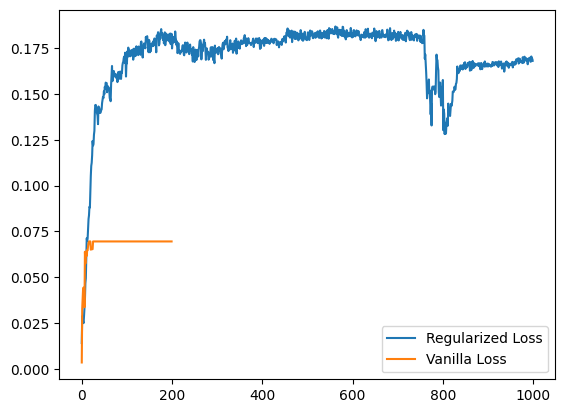

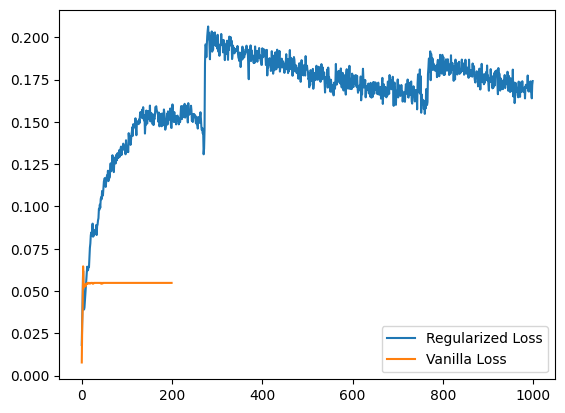

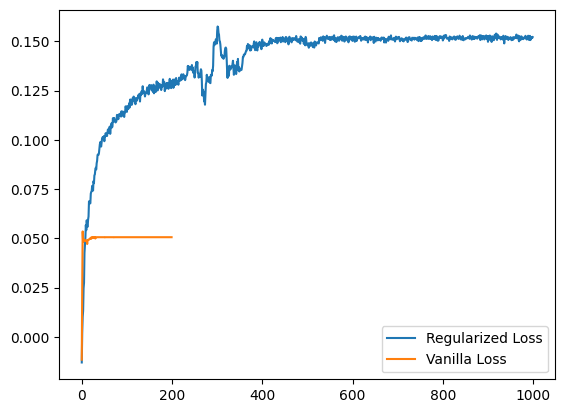

In [ ]:
gen_trajectory_plots(reg_trajectories, vanilla_trajectories)

In [ ]:
def successful_runs(opt_values, trajectories):
    num = 0
    total = 0
    for opt, trajectory in zip(opt_values, trajectories):
        results = -np.array(trajectory)
        best_score = max(results)
        if abs(opt - best_score) < 0.95 :
            num = num + 1
        total = total + 1

    return (total, num)



In [ ]:
successful_runs(-4*torch.stack(optimal_values), vanilla_trajectories)

(5, 0)

In [ ]:
successful_runs(-4* torch.stack(optimal_values), reg_trajectories)

(5, 0)

In [ ]:
[max(x) for x in vanilla_trajectories]

[132.0, 148.0, 152.0, 148.1199951171875, 152.0399932861328]

In [ ]:
[max(x) for x in reg_trajectories]

[144.0, 164.0, 163.0, 175.32000732421875, 159.39999389648438]

# Create Max-Cut Instance

In [ ]:
dimension = 500
degree = 20
find_opt = False

optimal_values = []
vanilla_trajectories = []

vanilla_scores = []
reg_trajectories = []

reg_scores = []
cut_value_list = []

G = nx.to_numpy_array(
    # nx.generators.random_graphs.gnp_random_graph(dimension, 0.5)).astype(int)
    nx.generators.random_graphs.random_regular_graph(degree, dimension)).astype(int)

Gt = torch.tensor(G, dtype=torch.float)

L = (torch.diag(torch.sum(Gt, axis=1)) - Gt).to(device)

if find_opt:

  def s(n):
      return np.array( [int(x) for x in bin(2**dimension + n)[2:]][1:] )
  def cut(n):
      return np.sum( G & (s(n)[:,None] < s(n)) )
  def st(n):
      return torch.tensor( [int(x) for x in bin(2**dimension + n)[2:]][1:] ).float()

  X = torch.stack([st(i) for i in range(2**dimension)])
  y = torch.tensor([cut(i) for i in range(2**dimension)]).float()
  opt = torch.max(y)
  print("The (normalized) value of Max-Cut is:",
        P_value(torch.max(y), degree, dimension))

else:
  y = []
  opt = -1.


cut_value_list.append(y)
optimal_values.append(opt)


# Vanilla

In [ ]:
iterations_vanilla = 100
step_size = 0.003
batch_size = 200
mala_steps = 1000

# Vanilla Cut Optimizer
with device:

  net = FastSlowMixture(dimension, 1.)
  # Define Optimizer
  opt = torch.optim.Adam(net.parameters(), lr=step_size)

  # Define MALA sampler
  mala_sampler = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=True)

  out, losses_vanilla = vanilla_cut_optimizer(net, opt, mala_sampler, mala_steps=mala_steps,
                                              iterations=iterations_vanilla, L=L)
vanilla_scores.append(out)
vanilla_trajectories.append(losses_vanilla)


Step 0 Mean Batch Score 0.06082111969590187
Step 10 Mean Batch Score 0.11627563834190369
Step 20 Mean Batch Score 0.137741819024086
Step 30 Mean Batch Score 0.14668609201908112
Step 40 Mean Batch Score 0.14668609201908112
Step 50 Mean Batch Score 0.14668609201908112
Step 60 Mean Batch Score 0.14668609201908112
Step 70 Mean Batch Score 0.14668609201908112
Step 80 Mean Batch Score 0.14668609201908112
Step 90 Mean Batch Score 0.14668609201908112


# Hot/Cold + Regularization

In [ ]:
iterations_regularized = 300
new_reg_value = .1
reg_updates = 2
reg_scaling = 1.5
mix_prob = 0.1
rho = 0.03

with device:
  net = FastSlowMixture(dimension, rho)

  opt = torch.optim.Adam(net.parameters(), lr=step_size)

  # Define MALA sampler
  mala_sampler_cold = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=True)
  mala_sampler_hot = Sampler(net, (dimension,), sample_size=batch_size, max_len=8192, is_cold=False)

  cold_out, losses_regularized = hot_cold_cut_optimizer(net,
                                                        opt,
                                                        mala_sampler_cold=mala_sampler_cold,
                                                        mala_sampler_hot=mala_sampler_hot,
                                                        mala_steps=mala_steps,
                                                        iterations=iterations_regularized,
                                                        L=L,
                                                        reg_value=new_reg_value,
                                                        reg_updates=reg_updates,
                                                        reg_scaling=reg_scaling,
                                                        mix_prob=mix_prob)

reg_scores.append(cold_out)
reg_trajectories.append(losses_regularized)

Step 0 The score of hot samples  0.0019945658277720213 2502.22998046875
Step 0 The score of cold samples -0.0032109934836626053 2496.409912109375
Step 10 The score of hot samples  0.002379168989136815 2502.659912109375
Step 10 The score of cold samples 0.1463998407125473 2663.679931640625
Step 20 The score of hot samples  0.004203810356557369 2504.699951171875
Step 20 The score of cold samples 0.15205268561840057 2670.0
Step 30 The score of hot samples  -0.0008497051894664764 2499.050048828125
Step 30 The score of cold samples 0.15922589600086212 2678.02001953125
Step 40 The score of hot samples  0.0003846032777801156 2500.429931640625
Step 40 The score of cold samples 0.16278566420078278 2682.0
Step 50 The score of hot samples  -0.0006708252476528287 2499.25
Step 50 The score of cold samples 0.16278566420078278 2682.0
Step 60 The score of hot samples  -5.366273398976773e-05 2499.93994140625
Step 60 The score of cold samples 0.16278566420078278 2682.0
Step 70 The score of hot samples  

In [ ]:
degree = 40
dimension = 200
G = nx.to_numpy_array(
    nx.generators.random_graphs.random_regular_graph(degree, dimension)).astype(float)

G = (np.diag(np.sum(G, axis=1)) - G)

cut = goemans_williamson(G)
P_value(cost(torch.tensor(G),torch.tensor([cut])), degree, dimension)
cut

0.8197926409578381


array([ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1

tensor([0.6103], dtype=torch.float64)

In [ ]:
cost()